<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/240726_npp_analysis_cotubanama_national_park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

ee.Authenticate()

ee.Initialize(project='ee-foss4g')

In [81]:
# Cotubanama National Park
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

# Cotubanama National Park
# wdpa = wdpa.filter(ee.Filter.eq('WDPAID', 180))

# wdpa = wdpa.filter(ee.Filter.eq('WDPAID', 768))

# Valle Nuevo National Park
wdpa = wdpa.filter(ee.Filter.eq('WDPAID', 478142))

wdpa_name = wdpa.first().get('NAME').getInfo()
print("Name:", wdpa_name)

Name: Valle Nuevo


In [82]:
# 1: Pixel value for the outline, 2: Thickness of the outline (in pixels)
wdpa_raster = ee.Image().paint(wdpa, 1, 2)

# Set visualization parameters
wdpa_vis = {
    'palette': ['#FFFF00'], # Apply Yellow color
    'opacity': 1
}

m = geemap.Map(width="500px", height="350px",
               basemap='Esri.WorldImagery')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.centerObject(wdpa, 10)
m

Map(center=[18.792416623633116, -70.64776970012024], controls=(WidgetControl(options=['position', 'transparent…

In [83]:
dataset = (
    ee.ImageCollection('MODIS/061/MOD17A3HGF')
    .filterDate("2023-01-01", "2023-12-31")
    .filterBounds(wdpa)
)

# npp = dataset.select('Npp').first().clip(wdpa.geometry()).multiply(0.0001)
npp = dataset.select('Npp').first().multiply(0.0001)

crs = ee.Projection('EPSG:32619')
npp = npp.reproject(crs=crs, scale=500)

npp_vis = {
    'min': 0,
    'max': 1.9,
    'palette': ['bbe029', '0a9501', '074b03']
}

m = geemap.Map(width="500px", height="350px",
               basemap='Esri.WorldImagery')
m.addLayer(npp, npp_vis, 'NPP')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.centerObject(wdpa, 10)
m

Map(center=[18.792416623633116, -70.64776970012024], controls=(WidgetControl(options=['position', 'transparent…

In [84]:
# NPP 픽셀 값 합계 계산
npp_sum = npp.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=wdpa.geometry(),
    scale=500,
    maxPixels=1e13
).get('Npp').getInfo()

total_npp = npp_sum * 250000 * 0.001

# 결과 출력
print(f"{total_npp:.2f} Mg")

1441320.74 Mg


In [127]:
# Cotubanama National Park
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

# Cotubanama National Park
wdpa = wdpa.filter(ee.Filter.eq('WDPAID', 180))

# Valle Nuevo National Park
# wdpa = wdpa.filter(ee.Filter.eq('WDPAID', 478142))

In [130]:
# 날짜 범위 설정
start_date = '2023-01-01'
end_date = '2023-12-31'

# Dynamic World 이미지 컬렉션 필터링
dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
      .filterDate(start_date, end_date)
      .filterBounds(wdpa.geometry()))

# Dynamic World 이미지 컬렉션의 'label' 밴드 선택
classification = dw.select('label')

# 'mode' 리듀서를 사용하여 합성 이미지 생성
dw_composite = classification.reduce(ee.Reducer.mode())

# 시각화 매개변수 설정
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# 합성 이미지를 지리적 범위로 자르기
dw_composite_clipped = dw_composite.clip(wdpa.geometry())

m = geemap.Map(layout={'height':'400px', 'width':'700px'})
m.addLayer(dw_composite_clipped, dw_vis_params, 'Classified Composite')
m.add_legend(builtin_legend="Dynamic_World", title="Land Cover")
m.centerObject(dw_composite_clipped, 10)
m

Map(center=[18.206994216336522, -68.66592053893284], controls=(WidgetControl(options=['position', 'transparent…

In [131]:
# 토지 피복 클래스의 픽셀 수 계산
counts = dw_composite_clipped.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=wdpa.geometry(),
    scale=10,
    maxPixels=1e9
).getInfo()

# Dictionary에서 'label_mode' 키 값 가져오기
counts = counts['label_mode']

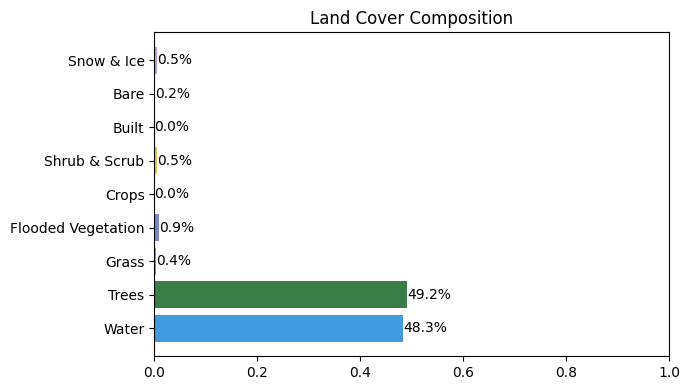

In [132]:
# 데이터프레임으로 변환
df = pd.DataFrame(list(counts.items()), columns=['Class', 'Count'])

# 클래스 이름 및 색상 매핑
class_names = ['Water', 'Trees', 'Grass', 'Flooded Vegetation', 'Crops', 'Shrub & Scrub', 'Built', 'Bare', 'Snow & Ice']
class_colors = ['#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']

# 클래스 이름과 색상을 매핑하여 데이터프레임에 추가
df['Class'] = df['Class'].astype(int)
df['Class Name'] = df['Class'].apply(lambda x: class_names[x] if x < len(class_names) else 'Unknown')
df['Color'] = df['Class'].apply(lambda x: class_colors[x] if x < len(class_colors) else '#000000')
df = df.sort_values(by='Class')

# 전체 픽셀 수 계산
total_count = df['Count'].sum()

# 각 클래스의 비율 계산
df['Percentage'] = df['Count'] / total_count

# 막대 그래프 생성 (수평 막대 그래프)
plt.figure(figsize=(7, 4))
bars = plt.barh(df['Class Name'], df['Percentage'], color=df['Color'])

# 퍼센트 레이블 추가
for bar, percentage in zip(bars, df['Percentage']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{percentage:.1%}', ha='left', va='center')

# plt.ylabel('Land Cover Class')
# plt.xlabel('Percentage')
plt.xlim(0, 1)
plt.title('Land Cover Composition')
plt.tight_layout()
plt.show()